# Lab Assignment Six: Convolutional Network Architectures

***Sahil Johari, Prabhat Pal, Pritheesh Panchmahalkar, Azeem Merchant***
<hr>

# 1.Business Understanding

# 2.Data Preparation

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns

import keras
from keras.layers import Dense, LSTM, GRU, SimpleRNN, Dropout
from keras.models import Model, Sequential
from keras.preprocessing.sequence import pad_sequences
from keras.layers.embeddings import Embedding
from keras.preprocessing.text import Tokenizer

from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import NullFormatter

from sklearn import metrics as mt
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold
from scipy import interp

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

import warnings
warnings.filterwarnings("ignore")

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
df = pd.read_csv('dataset/twitter.csv', encoding="ISO-8859-1")
df = df[:500]

df.shape

(500, 3)

In [4]:
df.head()

,ItemID,Sentiment,SentimentText
0,1,0,is so sad for my APL frie...
1,2,0,I missed the New Moon trail...
2,3,1,omg its already 7:30 :O
3,4,0,.. Omgaga. Im sooo im gunna CRy. I'...
4,5,0,i think mi bf is cheating on me!!! ...


In [5]:
X = np.array(df['SentimentText'])
y = np.array(df['Sentiment'])

n_samples = X.shape[0]
n_classes = len(np.unique(y))

print("n_samples: {}".format(n_samples))
print("n_classes: {}".format(n_classes))

n_samples: 500
n_classes: 2


Number of instances: 500
Number of instances in each class: [335 165]


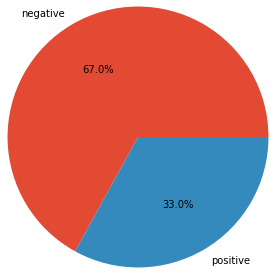

In [6]:
%matplotlib inline
plt.style.use('ggplot')

y_label = ['negative', 'positive']
print('Number of instances:', n_samples)
print('Number of instances in each class:', np.bincount(y))
the_grid = GridSpec(1, 1)

plt.subplot(the_grid[0, 0], aspect=1)
plt.pie(np.bincount(y), labels=y_label, autopct='%1.1f%%', radius=1.5)
plt.show()

# 3.Modeling

**Evaluation Metric**

The evaluation metric for this competition is Mean F1-Score. The F1 score, commonly used in information retrieval, measures accuracy using the statistics precision p and recall r. Precision is the ratio of true positives (tp) to all predicted positives (tp + fp). Recall is the ratio of true positives to all actual positives (tp + fn). The F1 score is given by:

$$F1 = 2\frac{p . r}{p+r} where p = \frac{tp}{tp+fp} and r = \frac{tp}{tp+fn}$$  

The F1 metric weights recall and precision equally, and a good retrieval algorithm will maximize both precision and recall simultaneously. Thus, moderately good performance on both will be favored over extremely good performance on one and poor performance on the other.

In [7]:
NUM_TOP_WORDS = None
MAX_ART_LEN = 1000 # maximum and minimum number of words

tokenizer = Tokenizer(num_words=NUM_TOP_WORDS)
tokenizer.fit_on_texts(df['SentimentText'])
sequences = tokenizer.texts_to_sequences(df['SentimentText'])

word_index = tokenizer.word_index
NUM_TOP_WORDS = len(word_index) if NUM_TOP_WORDS==None else NUM_TOP_WORDS
top_words = min((len(word_index),NUM_TOP_WORDS))
print('Found %s unique tokens. Distilled to %d top words.' % (len(word_index),top_words))

X = pad_sequences(sequences, maxlen=MAX_ART_LEN)

y_ohe = keras.utils.to_categorical(y)
print('Shape of data tensor:', X.shape)
print('Shape of label tensor:', y_ohe.shape)
print(np.max(X))

Found 2090 unique tokens. Distilled to 2090 top words.
Shape of data tensor: (500, 1000)
Shape of label tensor: (500, 2)
2090


In [9]:
sss = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=1)

In [10]:
for train_index, test_index in sss.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
y_train_ohe, y_test_ohe = keras.utils.to_categorical(y_train), keras.utils.to_categorical(y_test)

In [11]:
NUM_CLASSES = 2
print(X_train.shape,y_train_ohe.shape)

(400, 1000) (400, 2)


In [12]:
def build_embedding(embed_size, file_path):
    EMBED_SIZE = embed_size
    # the embed size should match the file you load glove from
    embeddings_index = {}
    f = open(file_path, encoding='utf8')
    # save key/array pairs of the embeddings
    #  the key of the dictionary is the word, the array is the embedding
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    f.close()
    print('Found %s word vectors.' % len(embeddings_index))

    # now fill in the matrix, using the ordering from the
    #  keras word tokenizer from before
    embedding_matrix = np.zeros((len(word_index) + 1, EMBED_SIZE))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector
    return embedding_matrix

In [13]:
EMBED_SIZE_100 = 100
EMBED_SIZE_200 = 200

embedding_matrix_100 = build_embedding(EMBED_SIZE_100, 'glove/glove.6B.100d.txt')
embedding_layer_100 = Embedding(len(word_index) + 1,
                            EMBED_SIZE_100,
                            weights=[embedding_matrix_100],
                            input_length=MAX_ART_LEN,
                            trainable=False)

# embedding_matrix_200 = build_embedding(EMBED_SIZE_200, 'glove/glove.6B.200d.txt')
# embedding_layer_200 = Embedding(len(word_index) + 1,
#                             EMBED_SIZE_200,
#                             weights=[embedding_matrix_200],
#                             input_length=MAX_ART_LEN,
#                             trainable=False)

Found 400000 word vectors.


In [20]:
def cross_val(cust_model, output_vector_size, embedding_layer, X_train, y_train, splits):
    scores = []
    i = 0
    skf = StratifiedKFold(n_splits=splits, shuffle=True, random_state=64)
    for train_idx, test_idx in skf.split(X_train, y_train):
        # build train and test samples from crossed cols and feature cols
        X_train_temp = X_train[train_idx]
        y_train_temp = keras.utils.to_categorical(y_train[train_idx])
        X_test_temp = X_train[test_idx]
        y_test_temp = keras.utils.to_categorical(y_train[test_idx])

        # rebuild model
        rnn = cust_model(output_vector_size, embedding_layer)

        # fit on train and predict on test
        rnn.fit(X_train_temp, y_train_temp, epochs=4, batch_size=64, verbose=0)
        pred = np.argmax(rnn.predict(X_test_temp), axis=1)

        # take cost
        s = mt.f1_score(y_train[test_idx], pred, average='binary')
        scores.append(s)

        print('Fold: %s, F1-score: %.3f' % (i+1, s))
        i += 1
    print('\nCV score: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

    plt.bar(range(len(scores)),scores)
    plt.ylim([min(scores)-0.01,max(scores)])

In [14]:
def rnn_model1(state_vector_size, embedding_layer):
    
    #create a custom embedding of output dimension 150
    embedding_layer_cust = Embedding(len(word_index) + 1,
                                150,
                                input_length=MAX_ART_LEN,
                                trainable=True,
                                name = "custom_embedding")
    rnn = Sequential()
    rnn.add(embedding_layer_cust)
    rnn.add(Dense(200, activation='relu'))
    rnn.add(Dropout(0.25))
    rnn.add(GRU(state_vector_size, dropout=0.2, recurrent_dropout=0.2))
    rnn.add(Dense(NUM_CLASSES, activation='softmax'))
    rnn.compile(loss='binary_crossentropy', 
                  optimizer='rmsprop', 
                  metrics=['accuracy'])
    return rnn

Fold: 1, F1-score: 0.000
Fold: 2, F1-score: 0.000

CV score: 0.000 +/- 0.000


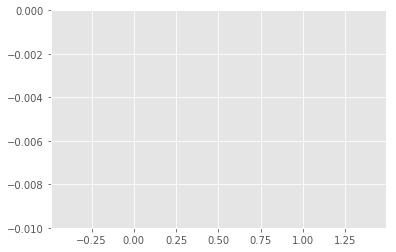

In [22]:
cross_val(rnn_model1, 100, embedding_layer_100, X_train, y_train, 2)

In [15]:
rnn_gru = rnn_model1(100, embedding_layer_100)
print(rnn_gru.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
custom_embedding (Embedding) (None, 1000, 150)         313650    
_________________________________________________________________
dense_1 (Dense)              (None, 1000, 200)         30200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 1000, 200)         0         
_________________________________________________________________
gru_1 (GRU)                  (None, 100)               90300     
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 202       
Total params: 434,352
Trainable params: 434,352
Non-trainable params: 0
_________________________________________________________________
None


In [16]:
history_gru = rnn_gru.fit(X_train, y_train_ohe, validation_data=(X_test, y_test_ohe), epochs=5, batch_size=64)
yhat = np.argmax(rnn_gru.predict(X_test), axis=1)
print("\nF-1 score:", mt.f1_score(y_test, yhat, average='binary'))

Train on 400 samples, validate on 100 samples
Epoch 1/5
256/400 [==================>...........] - ETA: 24s - loss: 0.6706 - acc: 0.6016

KeyboardInterrupt: 

In [25]:
def rnn_model2(state_vector_size, embedding_layer):
    rnn = Sequential()
    rnn.add(embedding_layer)
    rnn.add(Dense(500, activation='relu'))
    rnn.add(Dropout(0.3))
    rnn.add(LSTM(state_vector_size,dropout=0.2, recurrent_dropout=0.2))
    rnn.add(Dense(NUM_CLASSES, activation='softmax'))
    rnn.compile(loss='binary_crossentropy', 
                  optimizer='rmsprop', 
                  metrics=['accuracy'])
    return rnn

Fold: 1, F1-score: 0.000
Fold: 2, F1-score: 0.416

CV score: 0.208 +/- 0.208


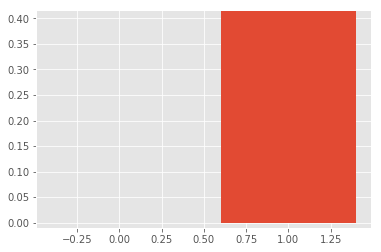

In [26]:
cross_val(rnn_model2, 100, embedding_layer_100, X_train, y_train, 2)

In [27]:
rnn_lstm = rnn_model2(100, embedding_layer_100)
print(rnn_lstm.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1000, 100)         209100    
_________________________________________________________________
dense_11 (Dense)             (None, 1000, 500)         50500     
_________________________________________________________________
dropout_6 (Dropout)          (None, 1000, 500)         0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               240400    
_________________________________________________________________
dense_12 (Dense)             (None, 2)                 202       
Total params: 500,202
Trainable params: 291,102
Non-trainable params: 209,100
_________________________________________________________________
None


In [28]:
history_lstm = rnn_lstm.fit(X_train, y_train_ohe, validation_data=(X_test, y_test_ohe), epochs=5, batch_size=64)
yhat = np.argmax(rnn_lstm.predict(X_test), axis=1)
print("\nF-1 score:", mt.f1_score(y_test, yhat, average='binary'))

Train on 400 samples, validate on 100 samples
Epoch 1/5
400/400 [==============================] - 90s 225ms/step - loss: 0.7186 - acc: 0.6550 - val_loss: 0.6316 - val_acc: 0.6700
Epoch 2/5
400/400 [==============================] - 86s 216ms/step - loss: 0.6189 - acc: 0.6725 - val_loss: 0.6249 - val_acc: 0.6500
Epoch 3/5
400/400 [==============================] - 87s 218ms/step - loss: 0.5974 - acc: 0.6925 - val_loss: 0.6867 - val_acc: 0.6900
Epoch 4/5
400/400 [==============================] - 87s 218ms/step - loss: 0.5859 - acc: 0.6975 - val_loss: 0.6145 - val_acc: 0.7000
Epoch 5/5
400/400 [==============================] - 87s 218ms/step - loss: 0.5393 - acc: 0.7100 - val_loss: 0.6011 - val_acc: 0.6700

F-1 score: 0.2978723404255319


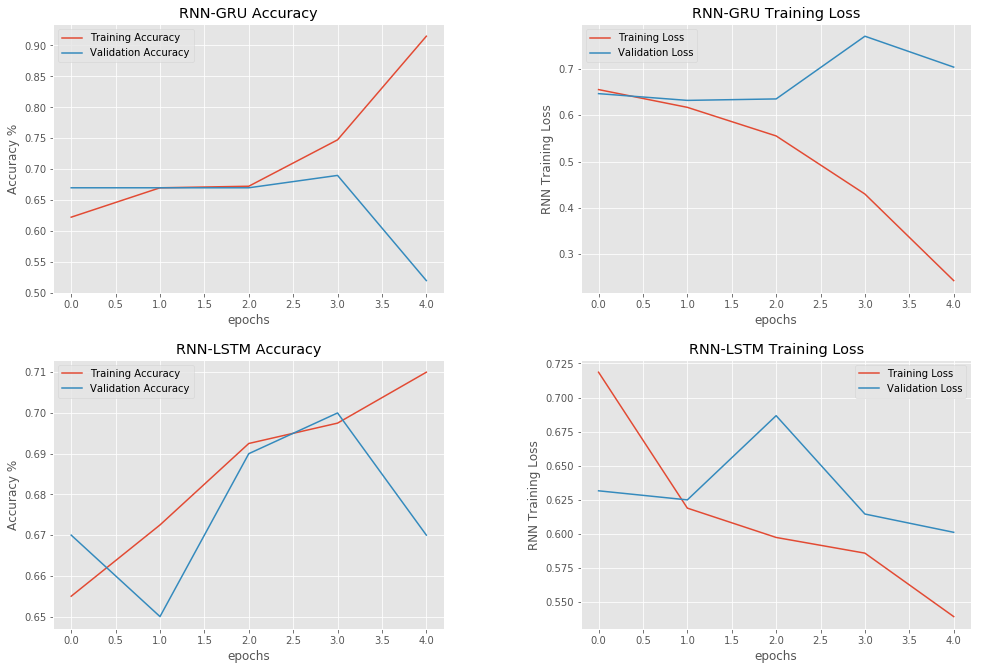

In [29]:
plt.figure(figsize=(15,10))
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25,
                    wspace=0.35)
plt.subplot(2,2,1)
plt.plot(history_gru.history['acc'], label="Training Accuracy")
plt.plot(history_gru.history['val_acc'], label="Validation Accuracy")
plt.xlabel('epochs')
plt.ylabel('Accuracy %')
plt.title('RNN-GRU Accuracy')
plt.legend(loc='best')

plt.subplot(2,2,2)
plt.plot(history_gru.history['loss'], label="Training Loss")
plt.plot(history_gru.history['val_loss'], label="Validation Loss")
plt.xlabel('epochs')
plt.ylabel('RNN Training Loss')
plt.title('RNN-GRU Training Loss')
plt.legend(loc='best')

plt.subplot(2,2,3)
plt.plot(history_lstm.history['acc'], label="Training Accuracy")
plt.plot(history_lstm.history['val_acc'], label="Validation Accuracy")
plt.xlabel('epochs')
plt.ylabel('Accuracy %')
plt.title('RNN-LSTM Accuracy')
plt.legend(loc='best')

plt.subplot(2,2,4)
plt.plot(history_lstm.history['loss'], label="Training Loss")
plt.plot(history_lstm.history['val_loss'], label="Validation Loss")
plt.xlabel('epochs')
plt.ylabel('RNN Training Loss')
plt.title('RNN-LSTM Training Loss')
plt.legend(loc='best')

In [ ]:
%matplotlib inline

def compare_models(rnn1, rnn2, X_test, y_test):
    plt.figure(figsize=(15,5))
    if rnn1 is not None:
        yhat_1 = np.argmax(rnn1.predict(X_test), axis=1)
        acc_1 = mt.f1_score(y_test,yhat_1, average='binary')
        plt.subplot(1,2,1)
        cm = mt.confusion_matrix(y_test,yhat_1)
        cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
        sns.heatmap(pd.DataFrame(cm, y_label, y_label), annot=True, fmt='.2f')
        plt.title('RNN-GRU: '+str(acc_1))
    
    if rnn2 is not None:
        yhat_2 = np.argmax(rnn2.predict(X_test), axis=1)
        acc_2 = mt.f1_score(y_test,yhat_2, average='binary')
        plt.subplot(1,2,2)
        cm = mt.confusion_matrix(y_test,yhat_2)
        cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
        sns.heatmap(pd.DataFrame(cm, y_label, y_label),annot=True, fmt='.2f')
        plt.title('RNN-LSTM: '+str(acc_2))

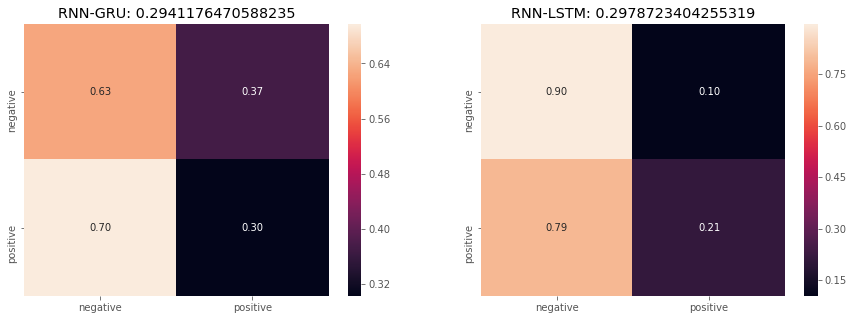

In [31]:
compare_models(rnn_gru, rnn_lstm, X_test, y_test)

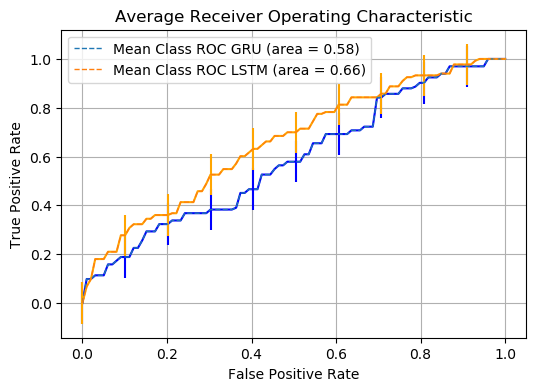

In [32]:
K = 4

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []

pred_1 = rnn_gru.predict(X_test)
pred_2 = rnn_lstm.predict(X_test)

# ROC for GRU
perclass_mean_tpr = 0.0
roc_auc = 0
classes = np.unique(y_train)

# get the mean fpr and tpr, per class
for j in classes:
    fpr, tpr, thresholds = roc_curve(y_test,
                                     pred_1[:,int(j)],
                                     pos_label=j)
    
    perclass_mean_tpr += interp(mean_fpr, fpr, tpr)
    perclass_mean_tpr[0] = 0.0
    roc_auc += auc(fpr, tpr)

perclass_mean_tpr /= len(classes)
roc_auc /= len(classes)
mean_tpr += perclass_mean_tpr
error = np.var(mean_fpr)
plt.style.use('default')

plt.figure(figsize=(6,4))
plt.plot(mean_fpr,perclass_mean_tpr,'--',lw=1,label='Mean Class ROC GRU (area = %0.2f)'
               % (roc_auc))
plt.errorbar(mean_fpr, perclass_mean_tpr, yerr=error, barsabove=True, errorevery=10, color='blue')


# ROC for LSTM
perclass_mean_tpr = 0.0
roc_auc = 0

# get the mean fpr and tpr, per class
for j in classes:
    fpr, tpr, thresholds = roc_curve(y_test,
                                     pred_2[:,int(j)],
                                     pos_label=j)
    
    perclass_mean_tpr += interp(mean_fpr, fpr, tpr)
    perclass_mean_tpr[0] = 0.0
    roc_auc += auc(fpr, tpr)

perclass_mean_tpr /= len(classes)
roc_auc /= len(classes)
mean_tpr += perclass_mean_tpr

error = np.var(mean_fpr)


plt.plot(mean_fpr,perclass_mean_tpr,'--',lw=1,label='Mean Class ROC LSTM (area = %0.2f)'
               % (roc_auc))
plt.errorbar(mean_fpr, perclass_mean_tpr, yerr=error, barsabove=True, errorevery=10, color='orange')

plt.legend(loc='best')
plt.grid()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Average Receiver Operating Characteristic')
plt.show()

### Adjust hyper-parameters of the networks

In [1]:
def GridSearch(rnn_model, param_grid):
    model_k = KerasClassifier(build_fn=rnn_model)
    grid = GridSearchCV(estimator=model_k, param_grid=param_grid, cv=2, verbose=1)
    grid_result = grid.fit(X_train, y_train_ohe)
    return grid_result

In [30]:
def print_result(grid_result):
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with: %r" % (mean, stdev, param))

In [22]:
def RandomizedSearch(rnn_model, param_grid):
    model_k = KerasClassifier(build_fn=rnn_model)
    random_search = RandomizedSearchCV(estimator=model_k, param_distributions=param_grid)
    random_search_result = grid.fit(X_train, y_train_ohe)
    return random_search_result

In [27]:
param_grid = dict(epochs=[1, 2], batch_size=[32, 64, 16], state_vector_size=[100, 50], 
                  embedding_layer=[embedding_layer_100])
random_search_result = RandomizedSearch(rnn_model1, param_grid)

Epoch 1/1
266/266 [==============================] - 5s 18ms/step
Epoch 1/1
267/267 [==============================] - 5s 18ms/step
Epoch 1/1
267/267 [==============================] - 5s 18ms/step
Epoch 1/2
266/266 [==============================] - 31s 117ms/step - loss: 0.6408 - acc: 0.6880
Epoch 2/2
266/266 [==============================] - 6s 22ms/step
Epoch 1/2
267/267 [==============================] - 29s 110ms/step - loss: 0.6416 - acc: 0.6779
Epoch 2/2
267/267 [==============================] - 7s 28ms/step
Epoch 1/2
267/267 [==============================] - 29s 109ms/step - loss: 0.6592 - acc: 0.6292
Epoch 2/2
267/267 [==============================] - 6s 23ms/step
Epoch 1/2
266/266 [==============================] - 40s 152ms/step - loss: 0.6555 - acc: 0.6053
Epoch 2/2
266/266 [==============================] - 6s 24ms/step
Epoch 1/2
267/267 [==============================] - 43s 161ms/step - loss: 0.6516 - acc: 0.6592
Epoch 2/2
267/267 [==============================] - 

In [ ]:
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_randomized_search.html

# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [29]:
report(grid_result.cv_results_)

Model with rank: 1
Mean validation score: 0.670 (std: 0.026)
Parameters: {'state_vector_size': 50, 'epochs': 1, 'embedding_layer': <keras.layers.embeddings.Embedding object at 0x000000000FB2C240>, 'batch_size': 32}

Model with rank: 1
Mean validation score: 0.670 (std: 0.026)
Parameters: {'state_vector_size': 100, 'epochs': 2, 'embedding_layer': <keras.layers.embeddings.Embedding object at 0x000000000FB2C240>, 'batch_size': 32}

Model with rank: 1
Mean validation score: 0.670 (std: 0.026)
Parameters: {'state_vector_size': 100, 'epochs': 2, 'embedding_layer': <keras.layers.embeddings.Embedding object at 0x000000000FB2C240>, 'batch_size': 64}

Model with rank: 1
Mean validation score: 0.670 (std: 0.026)
Parameters: {'state_vector_size': 100, 'epochs': 1, 'embedding_layer': <keras.layers.embeddings.Embedding object at 0x000000000FB2C240>, 'batch_size': 16}

Model with rank: 1
Mean validation score: 0.670 (std: 0.026)
Parameters: {'state_vector_size': 50, 'epochs': 1, 'embedding_layer': <k

In [31]:
# summarize results
print("Result summary for Model 1")
print_result(grid_result)

Result summary for Model 1
Best: 0.670000 using {'state_vector_size': 50, 'epochs': 1, 'embedding_layer': <keras.layers.embeddings.Embedding object at 0x000000000FB2C240>, 'batch_size': 32}
0.670000 (0.026026) with: {'state_vector_size': 50, 'epochs': 1, 'embedding_layer': <keras.layers.embeddings.Embedding object at 0x000000000FB2C240>, 'batch_size': 32}
0.670000 (0.026026) with: {'state_vector_size': 100, 'epochs': 2, 'embedding_layer': <keras.layers.embeddings.Embedding object at 0x000000000FB2C240>, 'batch_size': 32}
0.670000 (0.026026) with: {'state_vector_size': 100, 'epochs': 2, 'embedding_layer': <keras.layers.embeddings.Embedding object at 0x000000000FB2C240>, 'batch_size': 64}
0.670000 (0.026026) with: {'state_vector_size': 100, 'epochs': 1, 'embedding_layer': <keras.layers.embeddings.Embedding object at 0x000000000FB2C240>, 'batch_size': 16}
0.670000 (0.026026) with: {'state_vector_size': 50, 'epochs': 1, 'embedding_layer': <keras.layers.embeddings.Embedding object at 0x0000

In [37]:
# param_grid = dict(epochs=[1,3,5], batch_size=[32,64,128], state_vector_size=[100, 150], 
#                   embedding_layer=[embedding_layer_100, embedding_layer_200])
# grid_result = GridSearch(rnn_model2, param_grid)

In [38]:
# # summarize results
# print("Result summary for Model 2")
# print_result(grid_result)

### Add a second recurrent chain to your RNN

In [39]:
# https://machinelearningmastery.com/stacked-long-short-term-memory-networks/
def rnn_model2_stacked(state_vector_size, embedding_layer):
    rnn = Sequential()
    rnn.add(embedding_layer)
    rnn.add(Dense(500, activation='relu'))
    rnn.add(Dropout(0.3))
    rnn.add(LSTM(state_vector_size,dropout=0.2, recurrent_dropout=0.2, return_sequences=True, input_shape = (X_train.shape[1],)))
    rnn.add(LSTM(state_vector_size,dropout=0.2, recurrent_dropout=0.2))
    rnn.add(Dense(NUM_CLASSES, activation='softmax'))
    rnn.compile(loss='binary_crossentropy', 
                  optimizer='rmsprop', 
                  metrics=['accuracy'])
    return rnn

In [40]:
rnn_lstm_stacked = rnn_model2_stacked(100, embedding_layer_100)
print(rnn_lstm_stacked.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1000, 100)         209100    
_________________________________________________________________
dense_13 (Dense)             (None, 1000, 500)         50500     
_________________________________________________________________
dropout_7 (Dropout)          (None, 1000, 500)         0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 1000, 100)         240400    
_________________________________________________________________
lstm_5 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_14 (Dense)             (None, 2)                 202       
Total params: 580,602
Trainable params: 371,502
Non-trainable params: 209,100
________________________________________________________________

In [41]:
history_lstm_stacked = rnn_lstm_stacked.fit(X_train, y_train_ohe, validation_data=(X_test, y_test_ohe), epochs=3, batch_size=64)
yhat = np.argmax(rnn_lstm_stacked.predict(X_test), axis=1)
print("\nF-1 score:", mt.f1_score(y_test, yhat, average='binary'))

Train on 400 samples, validate on 100 samples
Epoch 1/3
400/400 [==============================] - 148s 371ms/step - loss: 0.6526 - acc: 0.6500 - val_loss: 0.7031 - val_acc: 0.4700
Epoch 2/3
400/400 [==============================] - 134s 335ms/step - loss: 0.6498 - acc: 0.6225 - val_loss: 0.6334 - val_acc: 0.6700
Epoch 3/3
400/400 [==============================] - 136s 341ms/step - loss: 0.6091 - acc: 0.6750 - val_loss: 0.6272 - val_acc: 0.6900

F-1 score: 0.1142857142857143


In [42]:
# TODO:
# Use the method of cross validation and evaluation criteria that you argued for at the beginning of the lab. 
# Visualize the results of all the RNNs you trained.  
# Use proper statistical comparison techniques to determine which method(s) is (are) superior

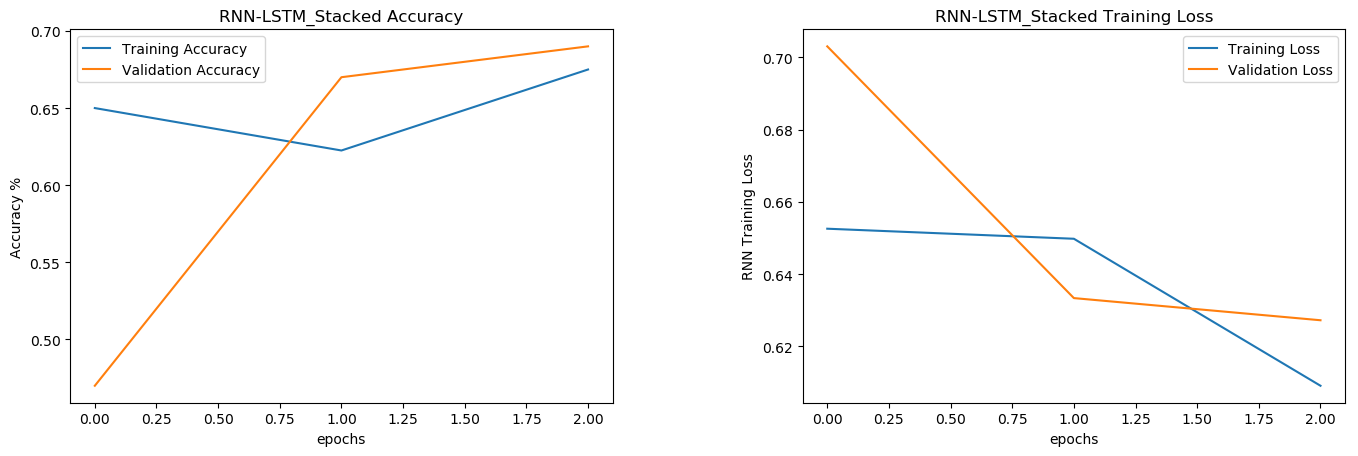

In [43]:
plt.figure(figsize=(15,10))
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25,
                    wspace=0.35)
plt.subplot(2,2,1)
plt.plot(history_lstm_stacked.history['acc'], label="Training Accuracy")
plt.plot(history_lstm_stacked.history['val_acc'], label="Validation Accuracy")
plt.xlabel('epochs')
plt.ylabel('Accuracy %')
plt.title('RNN-LSTM_Stacked Accuracy')
plt.legend(loc='best')

plt.subplot(2,2,2)
plt.plot(history_lstm_stacked.history['loss'], label="Training Loss")
plt.plot(history_lstm_stacked.history['val_loss'], label="Validation Loss")
plt.xlabel('epochs')
plt.ylabel('RNN Training Loss')
plt.title('RNN-LSTM_Stacked Training Loss')
plt.legend(loc='best')

In [50]:
# TODO:
# Use t-SNE (or SVD) to visualize the word embeddings of a subset of words in your vocabulary. 
# Try to interpret what each dimension reflects (in your own words). 
# That is, try to explain what aspect of the language is encoded in the reduced dimensionality embedding. 
embedding_matrix_100.shape

(2091, 100)

In [ ]:
def display_closestwords_tsnescatterplot(model, word):
    
    arr = np.empty((0,300), dtype='f')
    word_labels = [word]

    # get close words
    close_words = model.similar_by_word(word)
    
    # add the vector for each of the closest words to the array
    arr = np.append(arr, np.array([model[word]]), axis=0)
    for wrd_score in close_words:
        wrd_vector = model[wrd_score[0]]
        word_labels.append(wrd_score[0])
        arr = np.append(arr, np.array([wrd_vector]), axis=0)
        
    # find tsne coords for 2 dimensions
    tsne = TSNE(n_components=2, random_state=0)
    np.set_printoptions(suppress=True)
    Y = tsne.fit_transform(arr)

    x_coords = Y[:, 0]
    y_coords = Y[:, 1]
    # display scatter plot
    plt.scatter(x_coords, y_coords)

    for label, x, y in zip(word_labels, x_coords, y_coords):
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
    plt.xlim(x_coords.min()+0.00005, x_coords.max()+0.00005)
    plt.ylim(y_coords.min()+0.00005, y_coords.max()+0.00005)
    plt.show()

In [123]:
from gensim.models import KeyedVectors
model = gensim.models.KeyedVectors.load_word2vec_format(rnn_lstm)

NameError: name 'gensim' is not defined